# Training a neural network on MNIST with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation
import tensorflow_datasets as tfds
import numpy as np

## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Metal device set to: Apple M1


2022-07-18 09:06:00.037358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-18 09:06:00.037440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
for i in ds_train.take(5):
    print(i[0].shape)
    print(i[1])

(28, 28, 1)
tf.Tensor(4, shape=(), dtype=int64)
(28, 28, 1)
tf.Tensor(1, shape=(), dtype=int64)
(28, 28, 1)
tf.Tensor(0, shape=(), dtype=int64)
(28, 28, 1)
tf.Tensor(7, shape=(), dtype=int64)
(28, 28, 1)
tf.Tensor(8, shape=(), dtype=int64)


2022-07-18 09:06:00.077792: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-18 09:06:00.091939: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2022-07-18 09:06:00.313641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


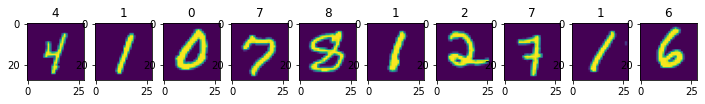

In [4]:
from matplotlib import pyplot as plt
import numpy as np
tmp = ds_train.take(10)
fig, axes = plt.subplots(1, 10, figsize = (12,4))
axes.flatten()
for i, d in enumerate(tmp):
    img = np.reshape(d[0], (28, 28))
    axes[i].imshow(img)
    axes[i].set_title(f"{d[1]}")

### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [5]:
def normalize_img(image, label):
    ''' Normalizes images: `uint8` -> `float32`.'''
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [6]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [51]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               100480    
                                                                 
 dense_38 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


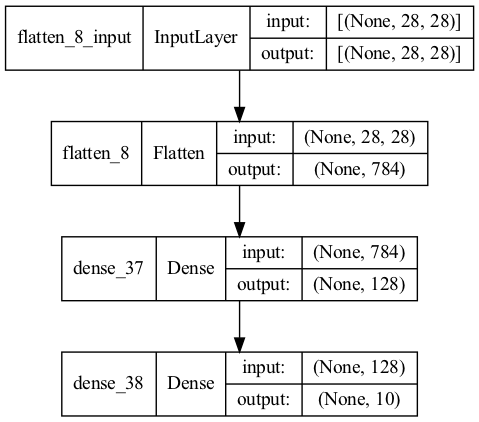

In [52]:
tf.keras.utils.plot_model(
    model, 
    to_file='model.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB', 
    dpi=100, 
    expand_nested=True
)

# Use tf.keras.Model to declare a Neural Network

In [23]:
wv_dim = 64
ff_dim = 1024
epsilon = 1e-6

In [32]:
def GetResidualNetwork():
    s_input = Input((28,28))
    m = Flatten()(s_input)
    m = Dense(wv_dim)(m)
    m2 = m
    
    for i in range(1):
        tmp = BatchNormalization(epsilon=epsilon)(m)
        tmp = Activation('relu')(tmp)
        tmp = Dense(ff_dim)(tmp)
        tmp = BatchNormalization(epsilon=epsilon)(tmp)
        tmp = Activation('relu')(tmp)
        tmp = Dense(wv_dim)(tmp)
        m = tf.add(tmp, m)
        
    for i in range(1):
        tmp = BatchNormalization(epsilon=epsilon)(m2)
        tmp = Activation('relu')(tmp)
        tmp = Dense(ff_dim)(tmp)
        tmp = BatchNormalization(epsilon=epsilon)(tmp)
        tmp = Activation('relu')(tmp)
        tmp = Dense(wv_dim)(tmp)
        m2 = tf.add(tmp, m2)
        
    m = tf.concat([m, m2], 0)
    
    out = Dense(10)(m)
    model = Model(
        s_input,
        out,
        name = 'residual_network',
    ) 
    return model

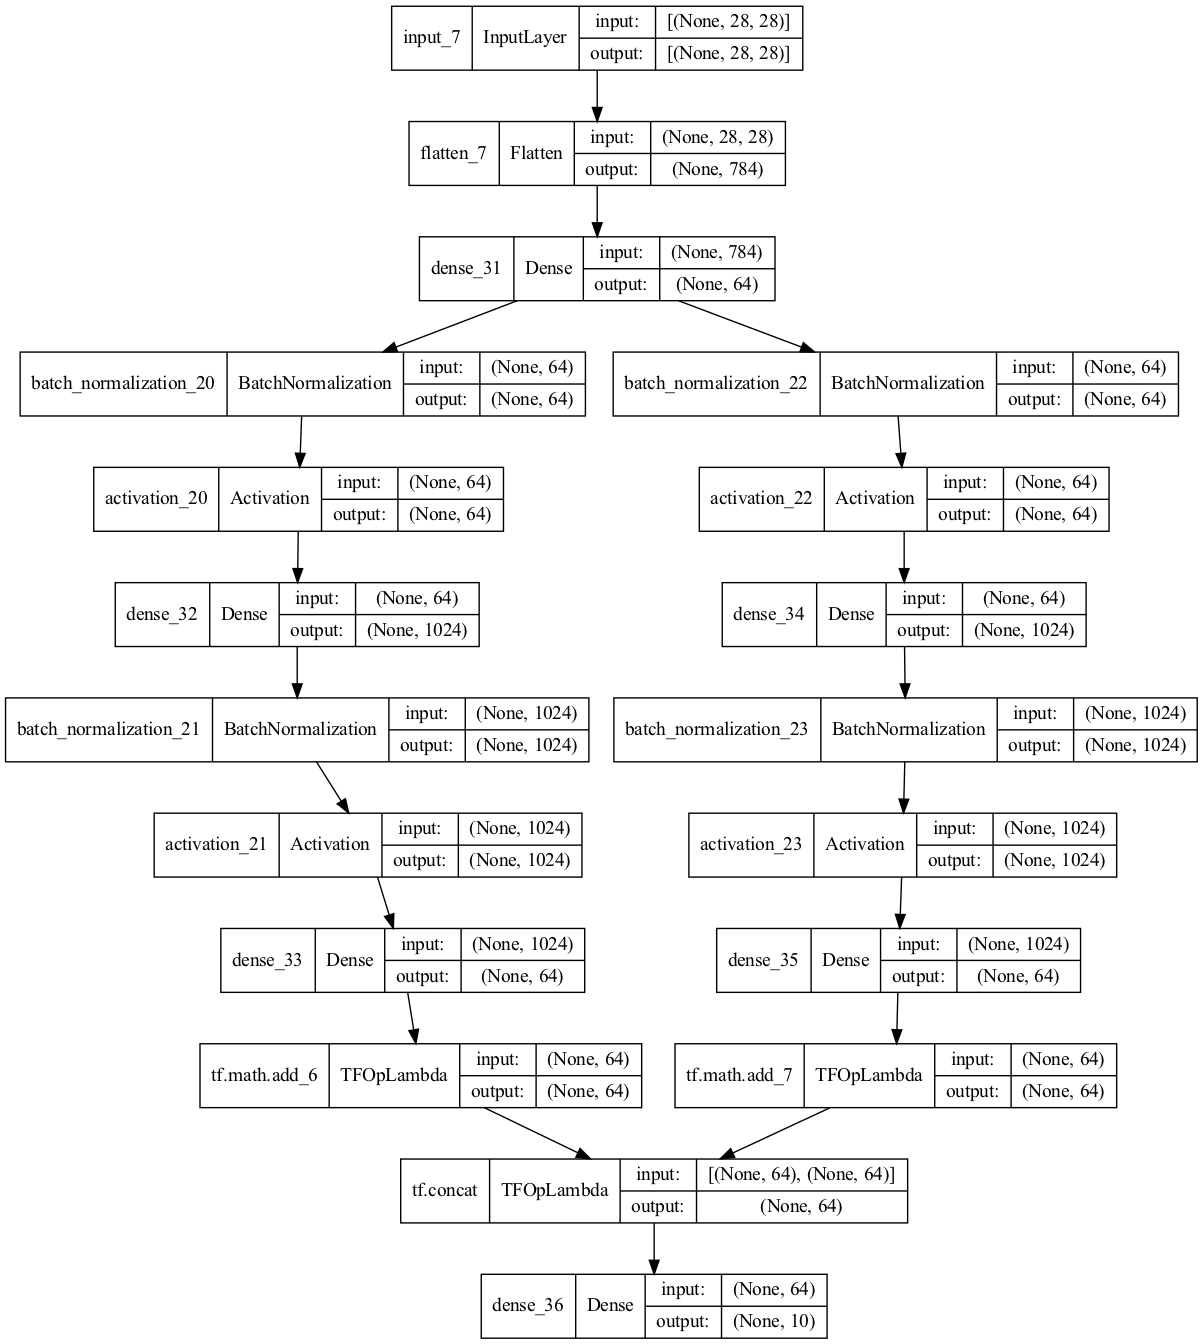

In [33]:
rn_model = GetResidualNetwork()
tf.keras.utils.plot_model(
    rn_model, 
    to_file='rn_model.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB', 
    dpi=100, 
    expand_nested=True
)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6


2022-07-18 08:56:20.316987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


468/469 [============================>.] - ETA: 0s - loss: 0.3567 - sparse_categorical_accuracy: 0.9025

2022-07-18 08:56:23.106419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 3s 5ms/step - loss: 0.3564 - sparse_categorical_accuracy: 0.9026 - val_loss: 0.2005 - val_sparse_categorical_accuracy: 0.9415
Epoch 2/6
469/469 [==============================] - 2s 5ms/step - loss: 0.1687 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.1415 - val_sparse_categorical_accuracy: 0.9586
Epoch 3/6
469/469 [==============================] - 2s 4ms/step - loss: 0.1197 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.1122 - val_sparse_categorical_accuracy: 0.9656
Epoch 4/6
469/469 [==============================] - 2s 4ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.0928 - val_sparse_categorical_accuracy: 0.9721
Epoch 5/6
469/469 [==============================] - 2s 4ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0827 - val_sparse_categorical_accuracy: 0.9746
Epoch 6/6
469/469 [==============================] - 2s 5ms/step - loss: 0.0600 - sparse_categorical_accuracy: 0.98

In [22]:
model.evaluate(ds_test)

79/79 [==============================] - 0s 3ms/step - loss: 0.0835 - sparse_categorical_accuracy: 0.9743


[0.08347229659557343, 0.9743000268936157]

# Show the model performance

[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 5 3 8 2 5 4 2
 5 5 8 5 2 9 2 4 2 7 0 5 1 0 7 9 9 9 6 5 8 8 6 9 9 5 4 2 6 8 1 0 6 9 5 5 4
 1 6 7 5 2 9 0 6 4 4 2 8 7 8 3 0 9 0 1 1 9 4 5 9 1 6 6 0 7 7 8 4 8 8 1 8 0
 2 9 1 0 3 9 7 0 4 9 6 8 9 3 5 4 3]
tf.Tensor(
[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3 8 7 5 4 2
 5 5 8 5 2 9 2 4 2 7 0 5 1 0 7 9 9 9 6 5 8 8 6 9 9 5 4 2 6 8 1 0 6 9 5 5 4
 1 6 7 5 2 9 0 6 4 4 2 8 7 8 3 0 9 0 1 1 9 4 5 9 7 6 6 0 7 7 8 4 8 8 1 8 0
 2 9 1 0 3 9 7 0 4 9 6 8 9 3 5 4 3], shape=(128,), dtype=int64)


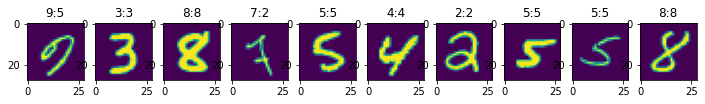

In [20]:
inp_evaluation_data = ds_test.take(1)
for data, label in inp_evaluation_data:
    pred = model(data)
    arg_pred = np.argmax(pred, axis = -1)
    print(arg_pred)
    print(label)
    
    fig, axes = plt.subplots(1, 10, figsize = (12,4))
    axes.flatten()
    imgs = np.reshape(data, (128, 28, 28))
    offset = 30
    for i, img in enumerate(imgs[offset:10+offset]):
        axes[i].imshow(img)
        axes[i].set_title(f"{label[i+offset]}:{arg_pred[i+offset]}")
    

# Gradient Tape
It is good to know.

In [53]:
model_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_optimizer = tf.keras.optimizers.Adam(0.001)

In [64]:
model.compile(
    optimizer=model_optimizer,
    loss=model_loss,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [60]:
@tf.function()
def train_step(img, label):
    y_true = label
    data = img
    with tf.GradientTape() as tape:
        y_pred = model(img)
        loss =model_loss(y_true, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)    
    model_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [65]:
tmp_data = ds_test.take(100)
for img, label in tmp_data:
    loss = train_step(img, label)
    print(loss)
    model.evaluate(ds_test)


48/79 [=================>............] - ETA: 0s - loss: 0.3390 - sparse_categorical_accuracy: 0.9045

2022-07-18 09:39:35.136215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 0s 4ms/step - loss: 0.2430 - sparse_categorical_accuracy: 0.9338


79/79 [==============================] - 0s 4ms/step - loss: 0.2409 - sparse_categorical_accuracy: 0.9340
